# Эксперимент 1

Анализ работы сети Кирилла Либериса

## Импорт зависимостей

In [1]:
import pathlib
import shutil
import os
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score

## Количество данных

In [2]:
data_dir = pathlib.Path("../data")
image_count = len(list(data_dir.glob("*/*.jpg")))

print("Количество изображений: ", image_count)

Количество изображений:  8203


In [3]:
blasts = list(data_dir.glob("./Бласты/*.jpg"))
lymphocytes = list(data_dir.glob("./Лимфоцит/*.jpg"))

print("Бласты: ", len(blasts),)
print("Лимфоциты: ", len(lymphocytes))

Бласты:  6628
Лимфоциты:  507


## Формирование выборок

- 200 бластов и 200 лимфоцитов для валидации

- 407 бластов и 407 лимфоцитов для тестирования и тренировки:

- 6528 бластов и 6528 лимфоцитов (original + rotated)

In [4]:
def random_fill_dir(ds_size, dir_name, paths, other_check_set=set()):
    """Функция для заполнения папок случайными выборками."""
    check_set = set()
    while len(check_set) != ds_size:
        # Выбираем случайный номер из списка
        random_path_i = random.randrange(len(paths))
        p = paths[random_path_i]
        
        # Если не использовали путь, добавляем в выборку
        if p not in check_set and p not in other_check_set:
            shutil.copyfile(p, dir_name + p.name)
            check_set.add(p)
    return check_set

In [4]:
# Очистка папки от данных
shutil.rmtree("./1_data")
os.makedirs("./1_data")

# -----------------------------------------------
# - тестовая выборка: 100 бластов и 100 лимфоцитов
os.makedirs("./1_data/test_ds/")
os.makedirs("./1_data/test_ds/blasts/")
os.makedirs("./1_data/test_ds/lymphocytes/")

# -- 100 бластов
test_blasts_paths = random_fill_dir(
    ds_size=100,
    dir_name="./1_data/test_ds/blasts/",
    paths=blasts,
)

# -- 100 лимфоцитов
test_lymphocytes_paths = random_fill_dir(
    ds_size=100,
    dir_name="./1_data/test_ds/lymphocytes/",
    paths=lymphocytes,
)

# - выборка с готовыми экспериментальными данными
os.makedirs("./1_data/exp/")
os.makedirs("./1_data/exp/blasts/")
os.makedirs("./1_data/exp/lymphocytes/")

# -- 407 бластов
blsts = random_fill_dir(
    ds_size=407,
    dir_name="./1_data/exp/blasts/",
    paths=blasts,
    other_check_set=test_blasts_paths,
)

# -- 407 лимфоцитов
lmphs = random_fill_dir(
    ds_size=407,
    dir_name="./1_data/exp/lymphocytes/",
    paths=lymphocytes,
    other_check_set=test_lymphocytes_paths,
)

# -----------------------------------------------
# - выборка с аугментацией данных
os.makedirs("./1_data/aug")
os.makedirs("./1_data/aug/blasts/")
os.makedirs("./1_data/aug/lymphocytes/")

# -- 6528 бластов
blsts = random_fill_dir(
    ds_size=6528,
    dir_name="./1_data/aug/blasts/",
    paths=blasts,
    other_check_set=test_blasts_paths,
)


# -- 6528 лимфоцитов (original + rotated)
for lymphocyte in lymphocytes:
    if lymphocyte not in test_lymphocytes_paths:
        shutil.copyfile(
            lymphocyte,
            "./1_data/aug/lymphocytes/" + lymphocyte.name
        )
        img = Image.open(lymphocyte)
        for i in range(15):
            img.rotate(24*(i+1))
            img.save("./1_data/aug/lymphocytes/" + str(24*(i+1)) + lymphocyte.name)

## Сборка модели перед тренировками

In [4]:
# Проверка на наличие GPU для тренировки
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Константы
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 192

EPOCHS = 10

class Model():
    def __init__(self):
        self.model = tf.keras.Sequential([
                tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                tf.keras.layers.MaxPooling2D(2, 2),
                tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D((2, 2)),
                tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(2, activation='softmax')
            ]
        )
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    def fit(self, train_ds, valid_ds):
        return self.model.fit(
            train_ds,
            validation_data=valid_ds,
            epochs=EPOCHS,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    restore_best_weights=True
                )
            ],
            verbose=2
        )
    def evaluate(self, test_ds):
        return self.model.evaluate(test_ds)
    
    def predict(self, test_ds):
        return self.model.predict(test_ds)

Num GPUs Available:  1


## Тренировка с различными размерами тренировочной и тестовой выборок

### Тестовая (контрольная) выборка

In [5]:
# Тестовые данные для натренированной модели
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()

test_ds = test_gen.flow_from_directory(
    directory="./1_data/test_ds",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42
)

Found 200 images belonging to 2 classes.


In [6]:
CLASS_NAMES = list(test_ds.class_indices.keys())
CLASS_NAMES

['blasts', 'lymphocytes']

### Функция для получения тренировочной и валидационной выборок

In [7]:
def get_train_data(validation_split_ratio: float, data_dir: str):
    """Возвращает тренировочную и валидационную выборки."""
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        validation_split=validation_split_ratio
    )
    train_ds = train_gen.flow_from_directory(
        directory=data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        subset="training",
    )

    valid_ds = train_gen.flow_from_directory(
        directory=data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        subset="validation",
    )
    return (train_ds, valid_ds)

### Тренировка модели на неагументированных данных

In [8]:
results = {}
for i in range(9):
    # Инициализация параметров
    ratio = round(0.1*(i+1), 2)
    results[ratio] = {}
    
    # Инициализация данных
    train_ds, valid_ds = get_train_data(
        validation_split_ratio=ratio,
        data_dir="./1_data/exp"
    )
    
    # Тренировка модели
    model = Model()
    callback = model.fit(train_ds, valid_ds)
    
    # Сохранение результатов
    # - Точность по эпохам
    acc_lst = callback.history['accuracy']
    val_acc_lst = callback.history['val_accuracy']
    results[ratio]['accuracy'] = acc_lst
    results[ratio]['val_accuracy'] = val_acc_lst
    
    # - Предсказание на тестовой (контрольной) выборке
    predictions = np.argmax(model.predict(test_ds), axis=1)
    results[ratio]['predictions'] = predictions

Found 734 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/10
23/23 - 5s - loss: 177.4801 - accuracy: 0.5545 - val_loss: 0.6893 - val_accuracy: 0.5750
Epoch 2/10
23/23 - 2s - loss: 0.6608 - accuracy: 0.5886 - val_loss: 0.6445 - val_accuracy: 0.5500
Epoch 3/10
23/23 - 2s - loss: 0.6042 - accuracy: 0.6662 - val_loss: 1.1404 - val_accuracy: 0.6250
Epoch 4/10
23/23 - 2s - loss: 0.5563 - accuracy: 0.7262 - val_loss: 0.6358 - val_accuracy: 0.6250
Epoch 5/10
23/23 - 2s - loss: 0.5133 - accuracy: 0.7548 - val_loss: 0.9855 - val_accuracy: 0.6500
Epoch 6/10
23/23 - 2s - loss: 0.4456 - accuracy: 0.7807 - val_loss: 1.0123 - val_accuracy: 0.6125
Epoch 7/10
23/23 - 2s - loss: 0.4155 - accuracy: 0.7861 - val_loss: 1.3060 - val_accuracy: 0.6500
Found 652 images belonging to 2 classes.
Found 162 images belonging to 2 classes.
Epoch 1/10
21/21 - 2s - loss: 62.8737 - accuracy: 0.5123 - val_loss: 1.1191 - val_accuracy: 0.5000
Epoch 2/10
21/21 - 2s - loss: 1.1517 - accuracy: 0

**Проверка результатов**

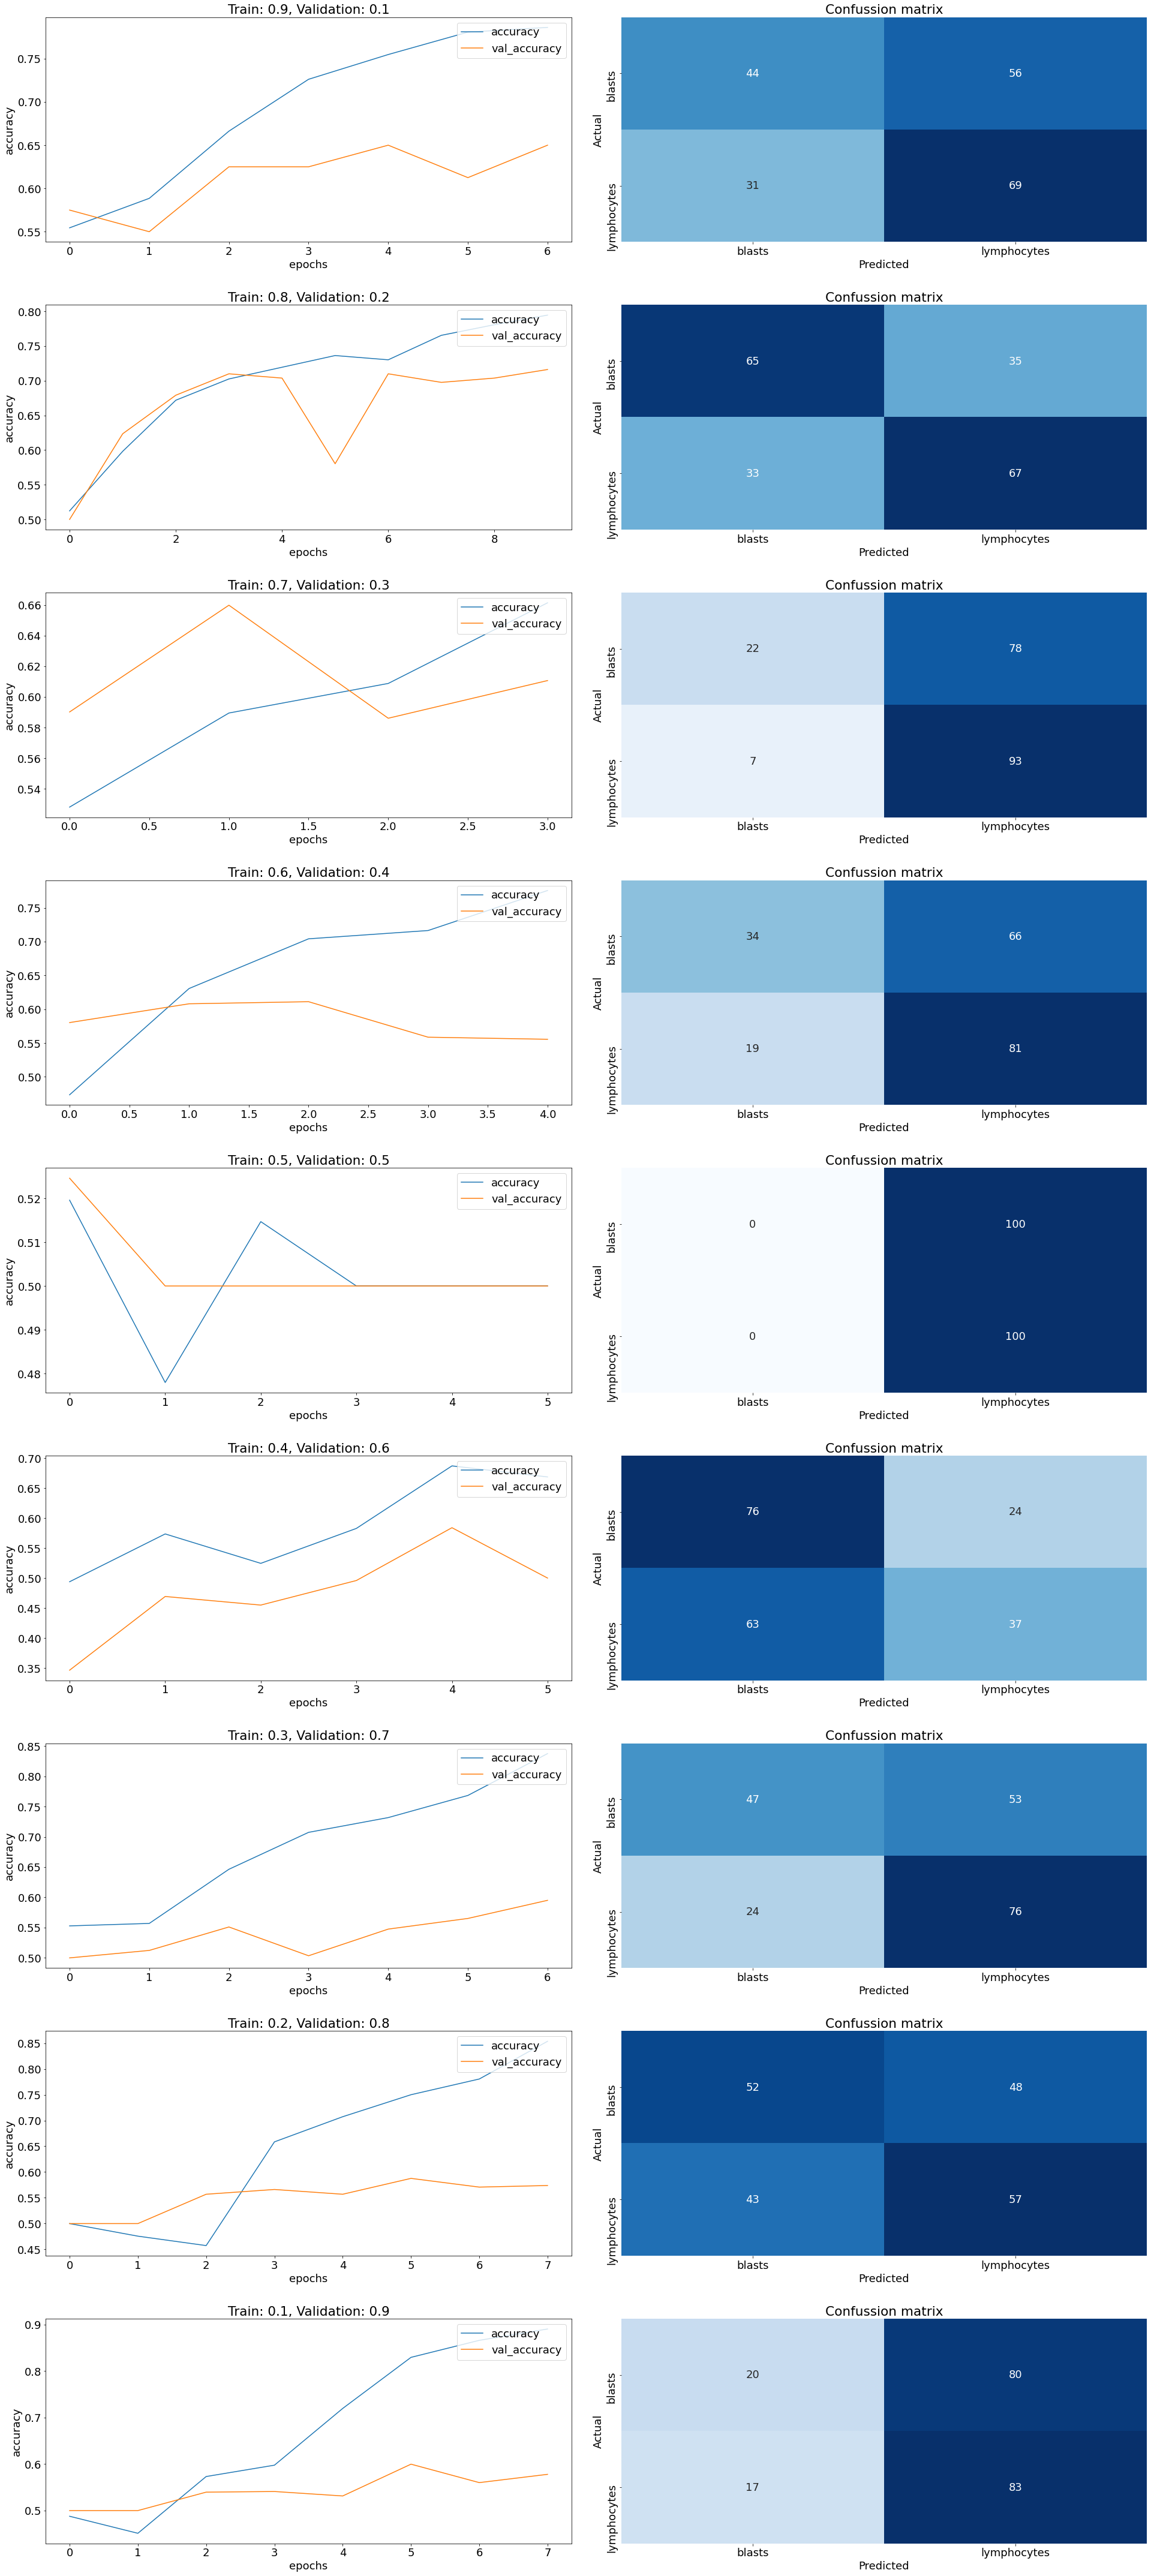

In [18]:
plt.figure(figsize=(27,60))
plt.rcParams.update({'font.size': 18})

j = 1
test_checks = []
for i in range(9):
    ratio = round(0.1*(i+1), 2)

    ax1 = plt.subplot(9, 2, j)
    j += 1
    ax2 = plt.subplot(9, 2, j)
    j += 1
    
    # Точность по эпохам
    ax1.plot(results[ratio]['accuracy'], label='accuracy')
    ax1.plot(results[ratio]['val_accuracy'], label='val_accuracy')
    ax1.title.set_text(f"Train: {round(1-ratio, 2)}, Validation: {ratio}")
    ax1.set(xlabel="epochs", ylabel="accuracy")
    ax1.legend(loc='upper right')
    
    # Точность на тестовой (контрольной) выборке
    acc = accuracy_score(test_ds.labels, results[ratio]['predictions'])
    test_checks.append([ratio, acc])

    cm = tf.math.confusion_matrix(test_ds.labels, results[ratio]['predictions'])

    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    ax2.set_xticks(ticks= np.arange(2) + 0.5)
    ax2.set_xticklabels(CLASS_NAMES)
    ax2.set_yticks(ticks= np.arange(2) + 0.5)
    ax2.set_yticklabels(CLASS_NAMES)
    ax2.set(xlabel="Predicted", ylabel="Actual")
    ax2.title.set_text("Confussion matrix")

plt.tight_layout(h_pad=2, w_pad=2)
plt.show()    

**Точность на тестовой (контрольной) выборке**

In [23]:
df = pd.DataFrame(test_checks, columns=["Соотноешние", "Точность"])
df

,Соотноешние,Точность
0,0.1,0.565
1,0.2,0.660
2,0.3,0.575
3,0.4,0.575
4,0.5,0.500
5,0.6,0.565
6,0.7,0.615
7,0.8,0.545
8,0.9,0.515


### Тренировка модели на агументированных данных

In [24]:
results = {}
for i in range(4):
    # Инициализация параметров
    ratio = round(0.1*(i+1), 2)
    results[ratio] = {}
    
    # Инициализация данных
    train_ds, valid_ds = get_train_data(
        validation_split_ratio=ratio,
        data_dir="./1_data/aug"
    )
    
    # Тренировка модели
    model = Model()
    callback = model.fit(train_ds, valid_ds)
    
    # Сохранение результатов
    # - Точность по эпохам
    acc_lst = callback.history['accuracy']
    val_acc_lst = callback.history['val_accuracy']
    results[ratio]['accuracy'] = acc_lst
    results[ratio]['val_accuracy'] = val_acc_lst
    
    # - Предсказание на тестовой (контрольной) выборке
    predictions = np.argmax(model.predict(test_ds), axis=1)
    results[ratio]['predictions'] = predictions

Found 11737 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.
Epoch 1/10
367/367 - 27s - loss: 8.1747 - accuracy: 0.6852 - val_loss: 1.1145 - val_accuracy: 0.6431
Epoch 2/10
367/367 - 26s - loss: 0.3696 - accuracy: 0.8361 - val_loss: 0.5577 - val_accuracy: 0.8135
Epoch 3/10
367/367 - 26s - loss: 0.1889 - accuracy: 0.9267 - val_loss: 0.2126 - val_accuracy: 0.9110
Epoch 4/10
367/367 - 26s - loss: 0.0872 - accuracy: 0.9704 - val_loss: 0.3760 - val_accuracy: 0.8764
Epoch 5/10
367/367 - 26s - loss: 0.0462 - accuracy: 0.9860 - val_loss: 0.5703 - val_accuracy: 0.8626
Epoch 6/10
367/367 - 26s - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.6262 - val_accuracy: 0.8680
Found 10433 images belonging to 2 classes.
Found 2607 images belonging to 2 classes.
Epoch 1/10
327/327 - 25s - loss: 7.7210 - accuracy: 0.6285 - val_loss: 0.6182 - val_accuracy: 0.6858
Epoch 2/10
327/327 - 24s - loss: 0.5417 - accuracy: 0.7112 - val_loss: 0.6506 - val_accuracy: 0.6928
Epoch 3/10
327/327 - 2

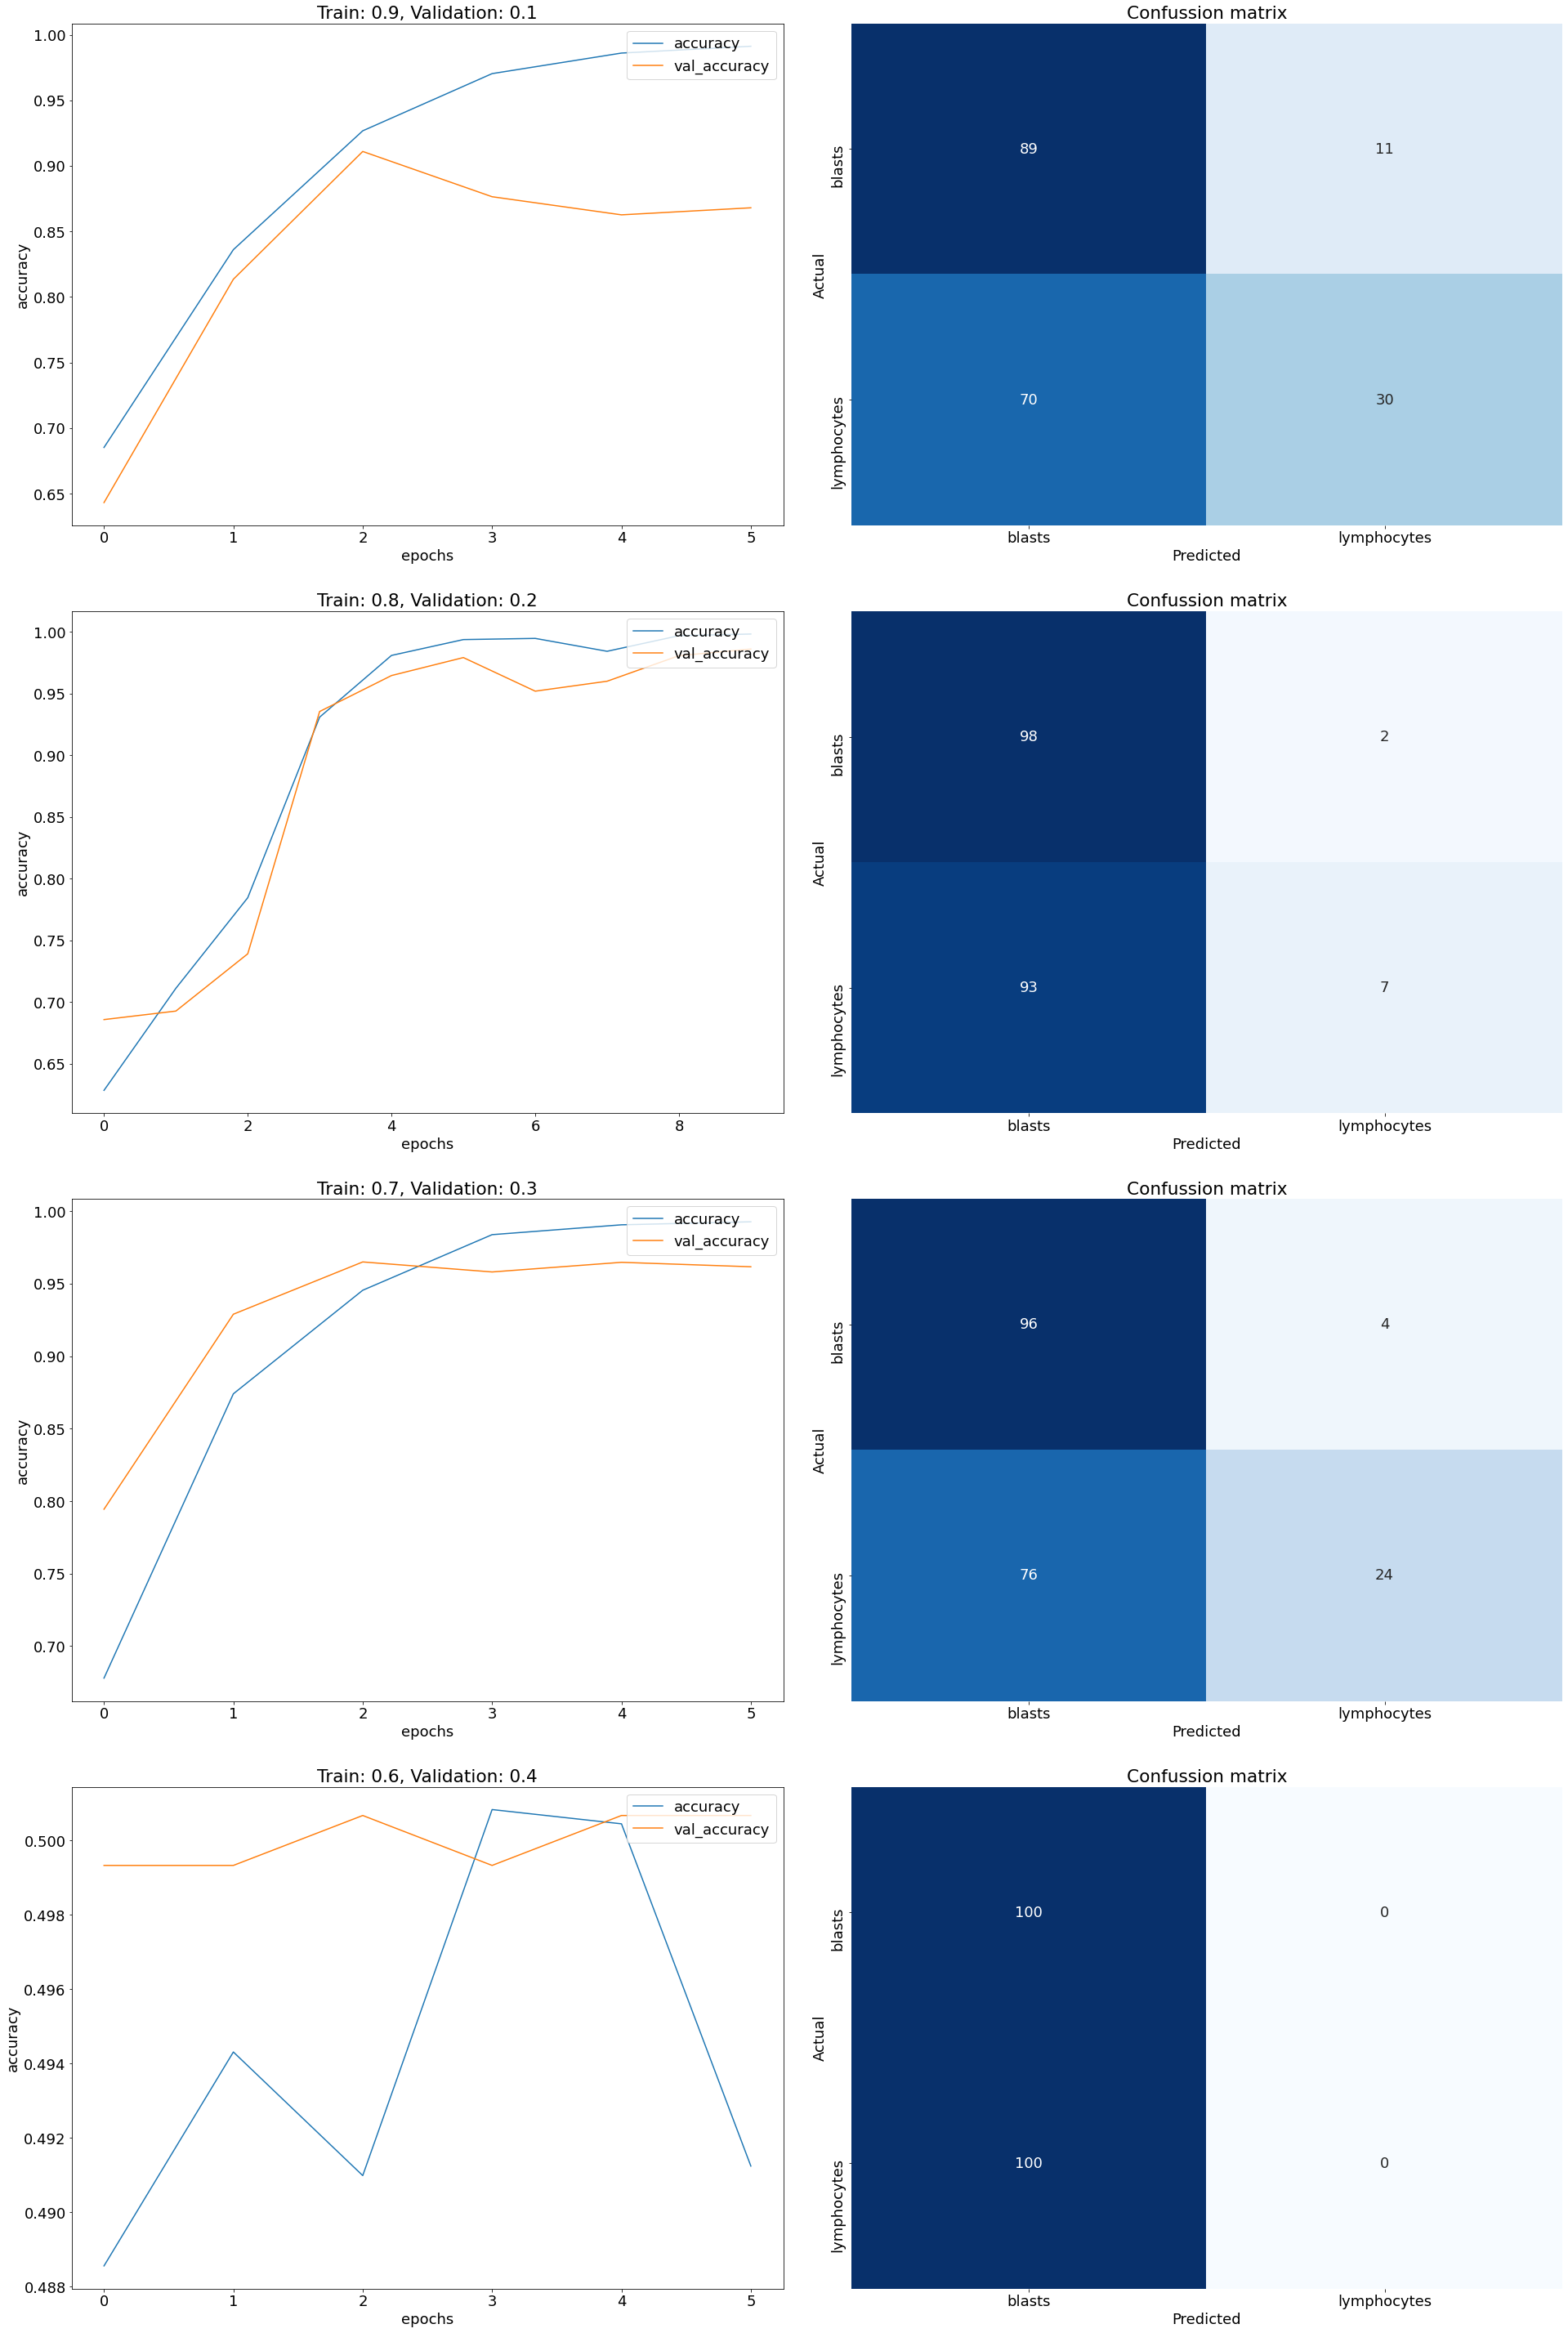

In [25]:
plt.figure(figsize=(27,40))
plt.rcParams.update({'font.size': 18})

j = 1
test_checks = []
for i in range(4):
    ratio = round(0.1*(i+1), 2)

    ax1 = plt.subplot(4, 2, j)
    j += 1
    ax2 = plt.subplot(4, 2, j)
    j += 1
    
    # Точность по эпохам
    ax1.plot(results[ratio]['accuracy'], label='accuracy')
    ax1.plot(results[ratio]['val_accuracy'], label='val_accuracy')
    ax1.title.set_text(f"Train: {round(1-ratio, 2)}, Validation: {ratio}")
    ax1.set(xlabel="epochs", ylabel="accuracy")
    ax1.legend(loc='upper right')
    
    # Точность на тестовой (контрольной) выборке
    acc = accuracy_score(test_ds.labels, results[ratio]['predictions'])
    test_checks.append([ratio, acc])

    cm = tf.math.confusion_matrix(test_ds.labels, results[ratio]['predictions'])

    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    ax2.set_xticks(ticks= np.arange(2) + 0.5)
    ax2.set_xticklabels(CLASS_NAMES)
    ax2.set_yticks(ticks= np.arange(2) + 0.5)
    ax2.set_yticklabels(CLASS_NAMES)
    ax2.set(xlabel="Predicted", ylabel="Actual")
    ax2.title.set_text("Confussion matrix")

plt.tight_layout(h_pad=2, w_pad=2)
plt.show()  

In [26]:
df = pd.DataFrame(test_checks, columns=["Соотноешние", "Точность"])
df

,Соотноешние,Точность
0,0.1,0.595
1,0.2,0.525
2,0.3,0.600
3,0.4,0.500
